BoradBand detection with automatic nosie detection

Teori:
Når man ser på amplituden til et signal og manulet estimerer hvor i signalet det kun er bakgrunnstøy, ser man etter et relativt flatt område med lav amplitude i forhold til resten av signalet.

Hyp: 
Om man kjører en hilbert transform av signalet og henter ut envelopen av signalet. der hvor envelopen har lav endring og lavest amplitude over tid bør være der hvor støyen i signalet ligger.

Signalet signal_med har blitt zero-padded under medfilt funksjonen. når programmet leter etter minste gjennomsnitts verdi for signalet, må hver ende av signalet kuttes. Ingen data som inkluderer en zero-padding kan inkluderes da disse er kuntig lave.

Hvor mye skal kuttes ned på hver side?
Disse linjene bestemmer hvor mye som skal midles:
    kernel_size = int(window_size*DS_Fs)+int(int(window_size*DS_Fs) % 2 == 0)
    signal_med = signal.medfilt(DS_Sx,kernel_size)
Dette fører til at verdiene fra [0:kernel_size] har inkludert zero-padding på venstre side, og [kernel_size:len(signal_med)-1] har inkludert padding på høyre.
Da vil alle valude data ligge på intervallet [kernel_size:-kernel_size]

nosie = -30.750460624694824
nosie = -43.10016632080078


/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_99747/1814143977.py:88: RuntimeWarning: divide by zero encountered in log10
  signal_vals = 10*np.log10(signal_med/nosie) - trigger


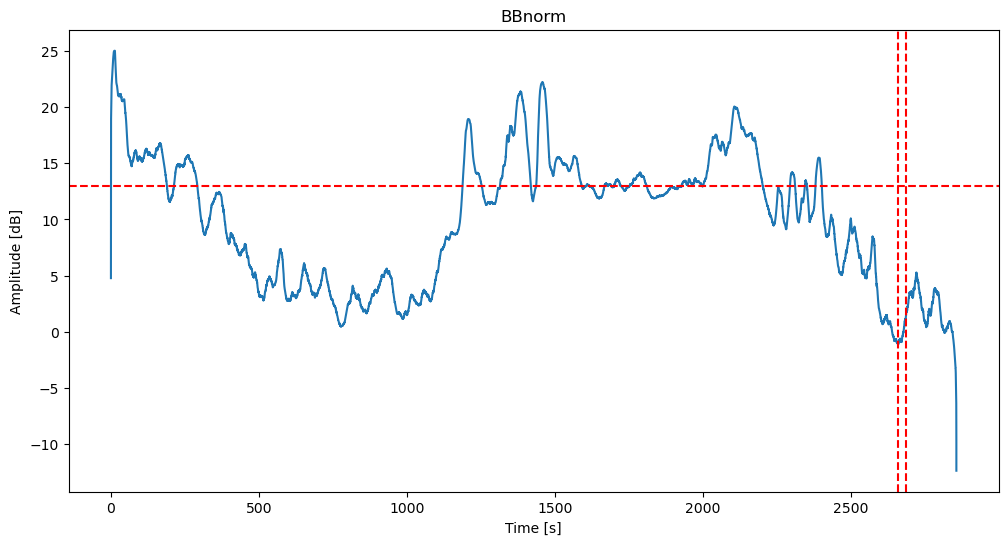

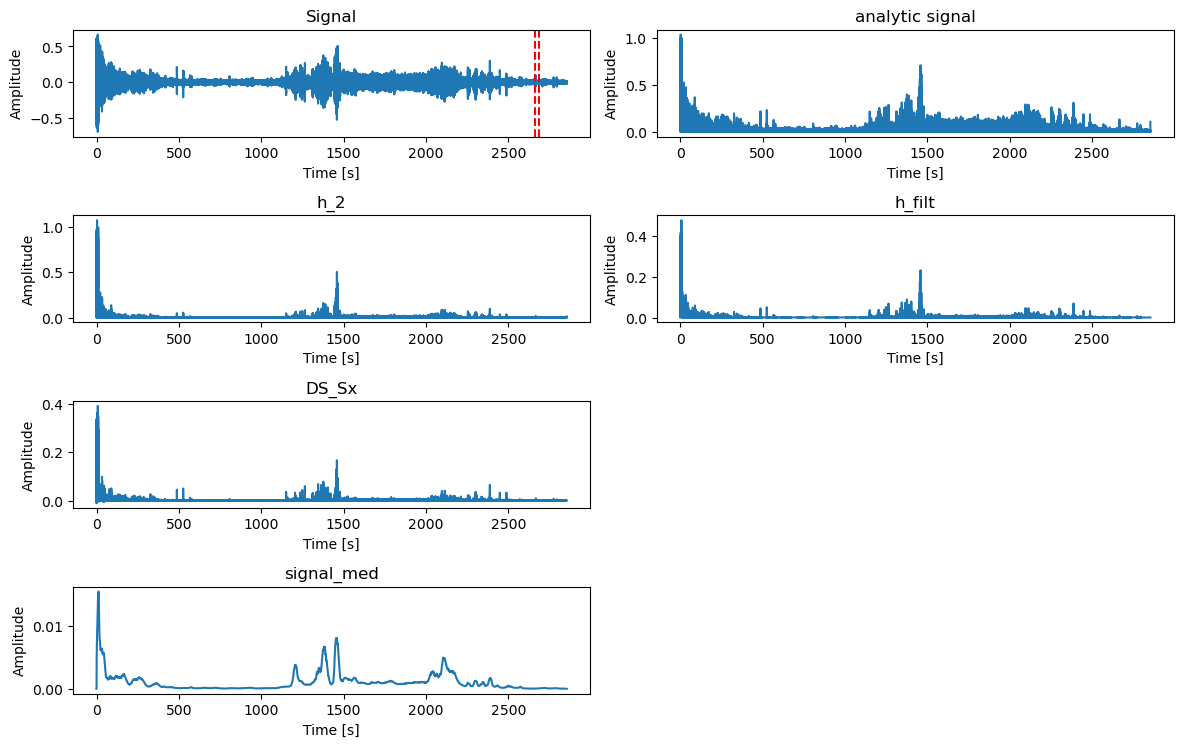

In [7]:
import librosa
import numpy as np
import scipy.signal as signal
from scipy.signal import resample_poly, hilbert
import matplotlib.pyplot as plt

#def BroadBand_from_file(input_file, Fds:int ,medfilt_window: int, window_size:int, nosie_t_start:int, trigger:int, plot:bool):

#Parameters:

input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/2.wav"

Fds=3000
medfilt_window=15
window_size=20
nosie_t_start=320
trigger=13
plot=True

#SOF

#Getting data from wav file
data_org, sr = librosa.load(input_file)
#data_org=data_org[int(600*sr):int(2e3*sr)]

window_size = int((len(data_org)/sr)*0.01)

#downsampling original audio data
data_offcet = resample_poly(data_org,1,int(sr/Fds))

#Removing Dc-offcet from data
dc_offcet = np.mean(data_offcet)
data = data_offcet - dc_offcet

#Hilbert transform ov data
analytic_signal = np.absolute(hilbert(data))
#Squaring each element
h_2 = np.square(analytic_signal)

#median filter
h_filt = signal.medfilt(h_2,medfilt_window)

#Downsampling
DS_Sx = resample_poly(h_filt,1,medfilt_window)
DS_Fs = Fds/medfilt_window
DS_t = np.linspace(0,(len(DS_Sx)/DS_Fs),len(DS_Sx))

# converting form seconds to samples
nosie_t_start = int(nosie_t_start*DS_Fs) 

nosie_t_stop = int(nosie_t_start+(window_size*DS_Fs))
nosie = np.mean(DS_Sx[nosie_t_start:nosie_t_stop])
print(f"nosie = {10*np.log10(nosie)}")
DS_Fs = int(DS_Fs)

kernel_size = int(window_size*DS_Fs)+int(int(window_size*DS_Fs) % 2 == 0)
signal_med = signal.medfilt(DS_Sx,kernel_size)


#Auto noise detection
signal_med2 =signal_med[kernel_size:-kernel_size]
# Step 1: Identify groups of consecutive similar values
indices = np.arange(len(signal_med2))
groups = np.split(indices, np.where(np.diff(signal_med2) != 0)[0] + 1)

# Step 2: Compute the average amplitude for each group
group_averages = np.array([np.mean(signal_med2[g]) for g in groups])

# Step 3: Determine the lowest average and define a threshold
min_avg = np.min(group_averages)
threshold = min_avg * 1.5  # Allow small variations

# Step 4: Find the longest group within the threshold
valid_groups = [g for g, avg in zip(groups, group_averages) if avg <= threshold]
longest_group = max(valid_groups, key=len) if valid_groups else None

if longest_group is None or len(longest_group) == 0:
    middle_index= None  # No valid group found

# Step 5: Return the middle index of the selected group
middle_index = kernel_size +longest_group[len(longest_group) // 2]
nosie_start = int(middle_index-(window_size*DS_Fs//2))
nosie_stop = int(middle_index+(window_size*DS_Fs//2))
nosie = np.mean(signal_med[nosie_start:nosie_stop])
print(f"nosie = {10*np.log10(nosie)}")


signal_vals = 10*np.log10(signal_med/nosie) - trigger

try:
    indices = np.where(signal_vals > 0)[0]
    Trigger_time = indices/DS_Fs
except:
    Trigger_time = 0
    print("Warning: Trigger is too high")
    print("No trigger time registerd")

if plot ==True:
    BBnorm_t = np.linspace(0,(len(signal_vals)/DS_Fs),len(signal_vals))

    plt.figure(figsize=(12,6))

    plt.plot(BBnorm_t,signal_vals + trigger)
    plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")
    plt.axvline(x=nosie_start/DS_Fs, color='red', linestyle='--')
    plt.axvline(x=nosie_stop/DS_Fs, color='red', linestyle='--')
    plt.title("BBnorm")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [dB]")
    plt.show()


#Debug plotting


t = np.linspace(0,len(data)/Fds,len(data))

plt.figure(figsize=(12,9))
plt.subplot(5,2,1)
plt.plot(t,data)
plt.axvline(x=nosie_start/DS_Fs, color='red', linestyle='--')
plt.axvline(x=nosie_stop/DS_Fs, color='red', linestyle='--')
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")


plt.subplot(5,2,2)
plt.plot(t,analytic_signal)
plt.title("analytic signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")


plt.subplot(5,2,3)
plt.plot(t,h_2)
plt.title("h_2")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")


plt.subplot(5,2,4)
plt.plot(t,h_filt)
plt.title("h_filt")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")



plt.subplot(5,2,5)
plt.plot(DS_t,DS_Sx)
plt.title("DS_Sx")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")


plt.subplot(5,2,7)
plt.plot(DS_t,signal_med)
plt.title("signal_med")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")



plt.tight_layout()
plt.show()

    #return Trigger_time

Noise = -30.75038433074951 dB
Auto-detected noise = -43.10012340545654 dB


/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_98368/3467322070.py:90: RuntimeWarning: divide by zero encountered in log10
  signal_vals = 10 * np.log10(signal_med / noice) - trigger


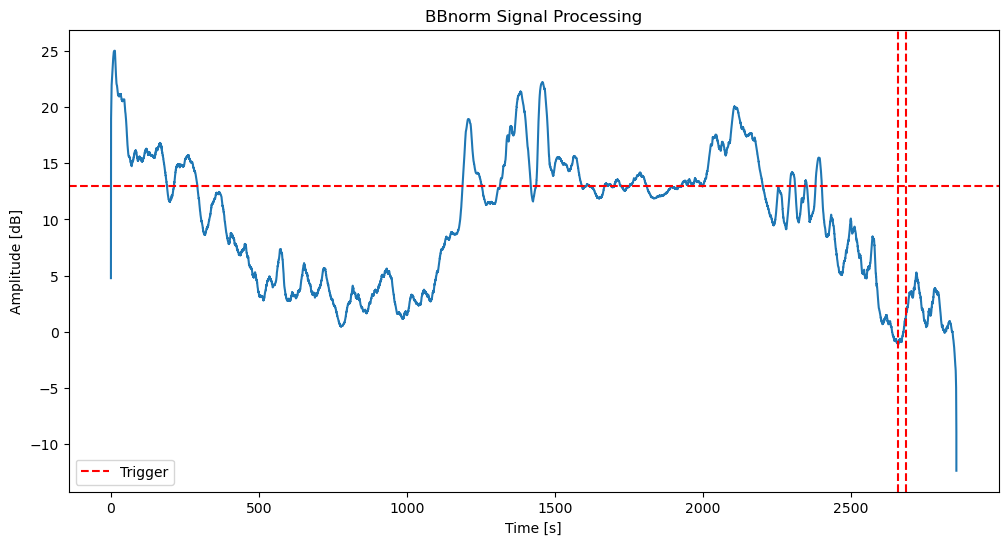

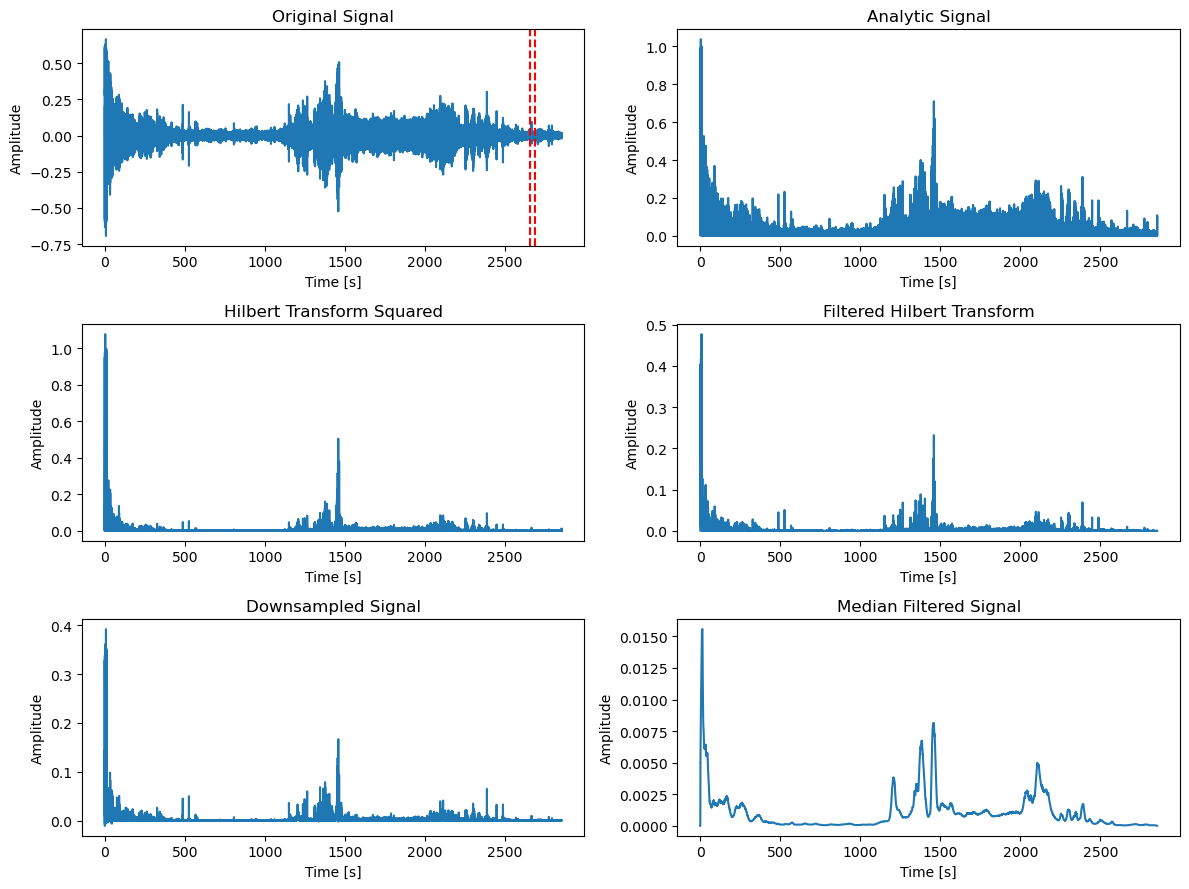

In [2]:
import librosa
import numpy as np
import scipy.signal as signal
from scipy.signal import resample_poly, hilbert
import matplotlib.pyplot as plt

# Parameters - User-defined settings
input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/2.wav"
Fds = 3000  # Target downsampling frequency
medfilt_window = 15  # Window size for median filtering
window_size = 20  # Window size for noise estimation (in seconds)
nosie_t_start = 320  # Noise estimation start time (in seconds)
trigger = 13  # Detection threshold in dB
plot = True  # Toggle for plotting results

# Load audio file without resampling
# librosa.load automatically normalizes values between -1 and 1
# sr=None ensures the original sampling rate is used

data_org, sr = librosa.load(input_file, sr=None)  
window_size = int((len(data_org) / sr) * 0.01)  # Recalculate window size in samples

# Downsampling using polyphase filtering for better efficiency
# This reduces the sampling rate to Fds (from original sr)
data_offcet = resample_poly(data_org, 1, int(sr / Fds))

# Remove DC offset (mean value) to center the signal around zero
dc_offcet = np.mean(data_offcet)
data = data_offcet - dc_offcet

# Apply Hilbert transform to obtain the analytic signal
analytic_signal = np.abs(hilbert(data))

# Square the amplitude envelope to enhance energy variations
h_2 = analytic_signal**2

# Apply median filtering to remove short-term fluctuations
h_filt = signal.medfilt(h_2, medfilt_window)

# Downsample the filtered signal for further processing
DS_Sx = resample_poly(h_filt, 1, medfilt_window)
DS_Fs = Fds / medfilt_window  # Adjusted sampling frequency
DS_t = np.linspace(0, len(DS_Sx) / DS_Fs, len(DS_Sx))  # Time axis for plotting

# Convert noise start time from seconds to sample index
nosie_t_start = int(nosie_t_start * DS_Fs)
nosie_t_stop = nosie_t_start + int(window_size * DS_Fs)

# Estimate noise level based on a selected window
nosie = np.mean(DS_Sx[nosie_t_start:nosie_t_stop])
print(f"Noise = {10 * np.log10(nosie)} dB")

# Ensure kernel size is odd for median filtering
kernel_size = int(window_size * DS_Fs) | 1  # Ensures odd value

# Apply median filtering for noise reduction
signal_med = signal.medfilt(DS_Sx, kernel_size)

# Automatic noise detection
# Extract portion of the signal without the first and last kernel_size samples
signal_med2 = signal_med[kernel_size:-kernel_size]

# Identify groups of consecutive similar values using diff()
diff_indices = np.where(np.diff(signal_med2) != 0)[0] + 1

# Split indices into groups where values are similar
groups = np.split(np.arange(len(signal_med2)), diff_indices)

# Compute average amplitude for each group
group_averages = np.array([np.mean(signal_med2[g]) for g in groups])

# Define a threshold as 1.5 times the minimum average amplitude
threshold = np.min(group_averages) * 1.5

# Select the longest group within the threshold
valid_groups = [g for g, avg in zip(groups, group_averages) if avg <= threshold]
longest_group = max(valid_groups, key=len, default=None)

# If no valid group found, set middle index to None
if longest_group is None or len(longest_group) == 0:
    middle_index = None  # No valid group found
else:
    middle_index = kernel_size + longest_group[len(longest_group) // 2]
    nosie_start = int(middle_index - (window_size * DS_Fs // 2))
    nosie_stop = int(middle_index + (window_size * DS_Fs // 2))
    nosie = np.mean(signal_med[nosie_start:nosie_stop])
    print(f"Auto-detected noise = {10 * np.log10(nosie)} dB")

# Compute signal values relative to noise threshold
signal_vals = 10 * np.log10(signal_med / nosie) - trigger

# Find indices where signal exceeds the threshold
indices = np.where(signal_vals > 0)[0]
Trigger_time = indices / DS_Fs if indices.size else 0

if indices.size == 0:
    print("Warning: Trigger too high, no trigger time registered")

# Plot the results if enabled
if plot:
    BBnorm_t = np.linspace(0, len(signal_vals) / DS_Fs, len(signal_vals))
    plt.figure(figsize=(12, 6))
    plt.plot(BBnorm_t, signal_vals + trigger)
    plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")
    plt.axvline(x=nosie_start / DS_Fs, color='red', linestyle='--')
    plt.axvline(x=nosie_stop / DS_Fs, color='red', linestyle='--')
    plt.title("BBnorm Signal Processing")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [dB]")
    plt.legend()
    plt.show()

    # Debugging plots
    t = np.linspace(0, len(data) / Fds, len(data))
    plt.figure(figsize=(12, 9))

    for i, (title, y) in enumerate(
        [
            ("Original Signal", data),
            ("Analytic Signal", analytic_signal),
            ("Hilbert Transform Squared", h_2),
            ("Filtered Hilbert Transform", h_filt),
            ("Downsampled Signal", DS_Sx),
            ("Median Filtered Signal", signal_med),
        ]
    ):
        plt.subplot(3, 2, i + 1)
        plt.plot(t if i <= 3 else DS_t, y)
        plt.title(title)
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        if i == 0:
            plt.axvline(x=nosie_start / DS_Fs, color='red', linestyle='--')
            plt.axvline(x=nosie_stop / DS_Fs, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()


noice = -30.750460624694824
noice = -43.10016632080078


/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_98368/1478757604.py:85: RuntimeWarning: divide by zero encountered in log10
  signal_vals = 10 * np.log10(signal_med / noice) - trigger


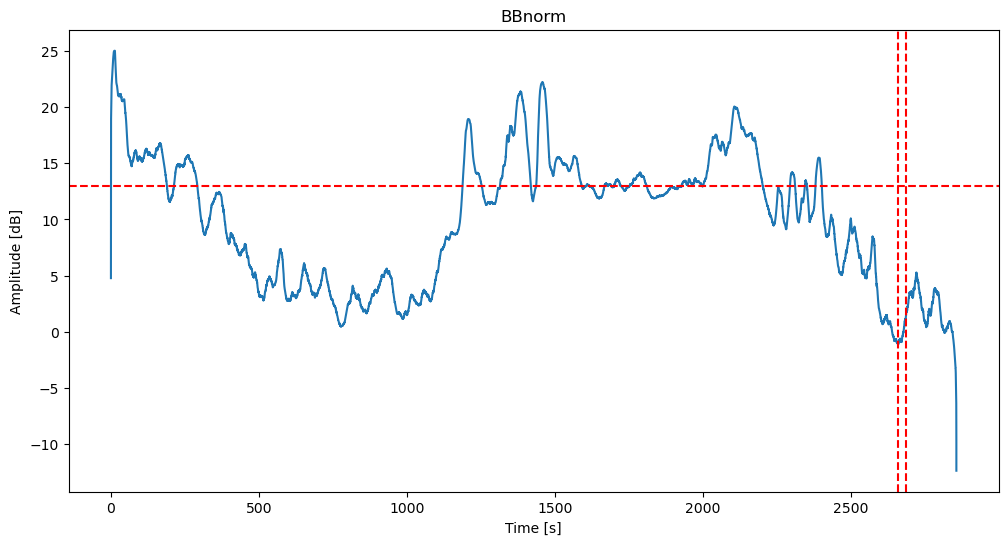

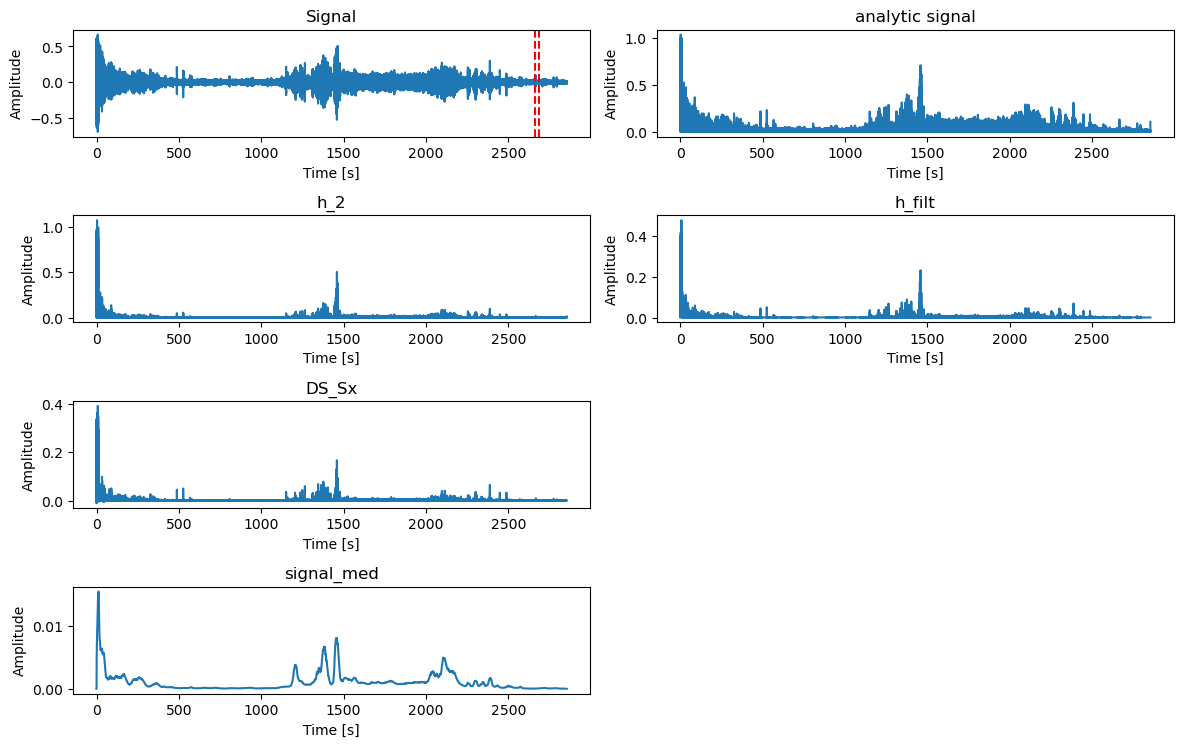

In [ ]:
import librosa  # Library for audio analysis
import numpy as np  # Library for numerical operations
import scipy.signal as signal  # Signal processing functions
from scipy.signal import resample_poly, hilbert  # Resampling and Hilbert transform
import matplotlib.pyplot as plt  # For plotting the results

# Parameters for the processing
input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/2.wav"  # Path to the input audio file
Fds = 3000  # Desired sampling frequency for downsampling
medfilt_window = 15  # Window size for the median filter
window_size = 20  # Window size for noise estimation
nosie_t_start = 320  # Start time for noise estimation (in seconds)
trigger = 13  # Trigger threshold for detecting events
plot = True  # Whether to plot the results or not

# Load audio data from the input file
data_org, sr = librosa.load(input_file)  # Load the file, returns the audio signal and its sampling rate

# Adjust window size based on audio length
window_size = int((len(data_org) / sr) * 0.01)  # Window size as a fraction of the total signal length

# Downsample the original audio data to the desired sampling frequency
data_offcet = resample_poly(data_org, 1, int(sr / Fds))  # Resampling the signal to Fds

# Remove DC offset by subtracting the mean value
dc_offcet = np.mean(data_offcet)  # Calculate the mean value of the signal
data = data_offcet - dc_offcet  # Remove the mean (DC offset)

# Apply Hilbert transform to get the analytic signal (used for envelope extraction)
analytic_signal = np.absolute(hilbert(data))  # Get the magnitude of the analytic signal
# Square the analytic signal to get the power envelope
h_2 = np.square(analytic_signal)

# Apply a median filter to smooth the envelope
h_filt = signal.medfilt(h_2, medfilt_window)  # Median filter for noise reduction

# Downsample the filtered signal
DS_Sx = resample_poly(h_filt, 1, medfilt_window)  # Resample by the median filter window size
DS_Fs = Fds / medfilt_window  # New sampling rate after downsampling
DS_t = np.linspace(0, (len(DS_Sx) / DS_Fs), len(DS_Sx))  # Time vector for the downsampled signal

# Convert noise start time from seconds to samples
nosie_t_start = int(nosie_t_start * DS_Fs)

# Calculate noise region (start and stop indices)
nosie_t_stop = int(nosie_t_start + (window_size * DS_Fs))
# Calculate the average noise level in this region
nosie = np.mean(DS_Sx[nosie_t_start:nosie_t_stop])
print(f"nosie = {10 * np.log10(nosie)}")  # Print the noise level in dB
DS_Fs = int(DS_Fs)  # Convert sampling rate to integer

# Define kernel size for the median filter based on window size
kernel_size = int(window_size * DS_Fs) + int(int(window_size * DS_Fs) % 2 == 0)
signal_med = signal.medfilt(DS_Sx, kernel_size)  # Apply median filter for further noise removal

# Auto noise detection: Identify long segments of similar values
signal_med2 = signal_med[kernel_size:-kernel_size]  # Remove edges affected by filter size
# Step 1: Identify consecutive regions with the same value (groups)
indices = np.arange(len(signal_med2))  # Create an array of indices
groups = np.split(indices, np.where(np.diff(signal_med2) != 0)[0] + 1)  # Split into groups of similar values

# Step 2: Compute the average amplitude for each group
group_averages = np.array([np.mean(signal_med2[g]) for g in groups])

# Step 3: Define a threshold based on the lowest average amplitude
min_avg = np.min(group_averages)  # Minimum group average
threshold = min_avg * 1.5  # Threshold to allow some variation

# Step 4: Find the longest group that is below the threshold
valid_groups = [g for g, avg in zip(groups, group_averages) if avg <= threshold]
longest_group = max(valid_groups, key=len) if valid_groups else None  # Longest valid group

if longest_group is None or len(longest_group) == 0:
    middle_index = None  # No valid group found

# Step 5: Determine the middle index of the longest group
middle_index = kernel_size + longest_group[len(longest_group) // 2]
# Calculate the noise start and stop indices based on the middle of the group
nosie_start = int(middle_index - (window_size * DS_Fs // 2))
nosie_stop = int(middle_index + (window_size * DS_Fs // 2))
nosie = np.mean(signal_med[nosie_start:nosie_stop])  # Calculate the noise level again
print(f"nosie = {10 * np.log10(nosie)}")  # Print the updated noise level in dB

# Normalize the signal by the noise level and subtract the trigger threshold
signal_vals = 10 * np.log10(signal_med / nosie) - trigger

# Try to detect trigger times based on the normalized signal
try:
    indices = np.where(signal_vals > 0)[0]  # Indices where the signal exceeds zero
    Trigger_time = indices / DS_Fs  # Convert indices to time
except:
    Trigger_time = 0  # Set to 0 if no triggers are found
    print("Warning: Trigger is too high")  # Inform the user if no trigger time is registered
    print("No trigger time registered")

# If plotting is enabled, plot the results
if plot == True:
    BBnorm_t = np.linspace(0, (len(signal_vals) / DS_Fs), len(signal_vals))  # Time vector for the normalized signal

    plt.figure(figsize=(12, 6))  # Set up the figure for plotting
    plt.plot(BBnorm_t, signal_vals + trigger)  # Plot the normalized signal
    plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")  # Plot the trigger threshold
    plt.axvline(x=nosie_start / DS_Fs, color='red', linestyle='--')  # Mark the start of the noise window
    plt.axvline(x=nosie_stop / DS_Fs, color='red', linestyle='--')  # Mark the end of the noise window
    plt.title("BBnorm")  # Title of the plot
    plt.xlabel("Time [s]")  # X-axis label
    plt.ylabel("Amplitude [dB]")  # Y-axis label
    plt.show()  # Show the plot

# Debug plotting to visualize intermediate steps

t = np.linspace(0, len(data) / Fds, len(data))  # Time vector for the original signal

plt.figure(figsize=(12, 9))  # Set up the figure for debugging plots

# Plot various stages of the signal processing pipeline for debugging

plt.subplot(5, 2, 1)
plt.plot(t, data)  # Plot original signal
plt.axvline(x=nosie_start / DS_Fs, color='red', linestyle='--')
plt.axvline(x=nosie_stop / DS_Fs, color='red', linestyle='--')
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 2)
plt.plot(t, analytic_signal)  # Plot analytic signal
plt.title("analytic signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 3)
plt.plot(t, h_2)  # Plot squared analytic signal
plt.title("h_2")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 4)
plt.plot(t, h_filt)  # Plot filtered signal
plt.title("h_filt")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 5)
plt.plot(DS_t, DS_Sx)  # Plot downsampled signal
plt.title("DS_Sx")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 7)
plt.plot(DS_t, signal_med)  # Plot median filtered signal
plt.title("signal_med")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()  # Adjust layout for better presentation
plt.show()  # Show the debug plots

#return Trigger_time  # Uncomment to return the trigger time if needed


nosie = -43.10016632080078


/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_39539/99459902.py:69: RuntimeWarning: divide by zero encountered in log10
  signal_vals = 10 * np.log10(signal_med / nosie) - trigger


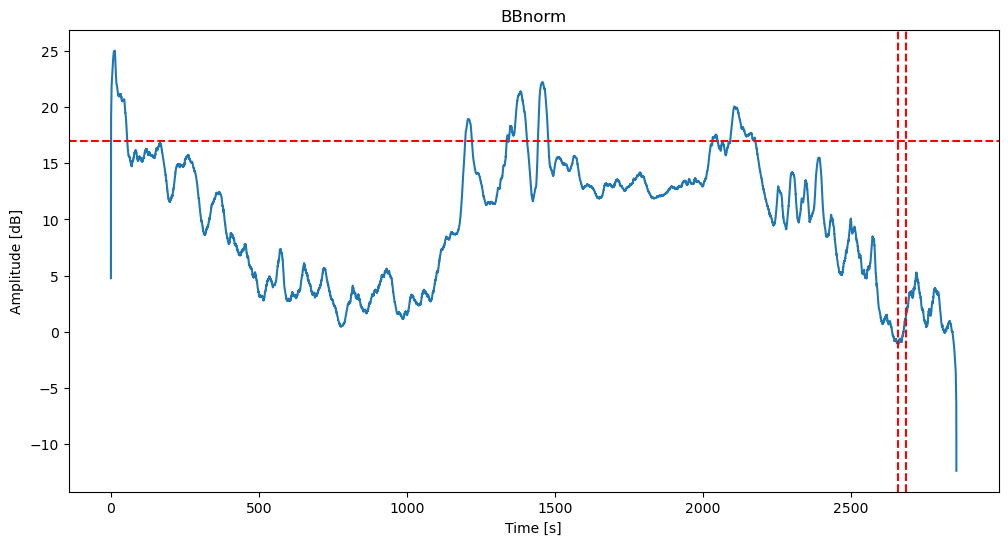

In [2]:
import librosa  # Library for audio analysis
import numpy as np  # Library for numerical operations
import scipy.signal as signal  # Signal processing functions
from scipy.signal import resample_poly, hilbert  # Resampling and Hilbert transform
import matplotlib.pyplot as plt  # For plotting the results

# Parameters for the processing
input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/2.wav"  # Path to the input audio file
Fds = 3000  # Desired sampling frequency for downsampling
medfilt_window = 15  # Window size for the median filter
trigger = 17  # Trigger threshold for detecting events
plot = True  # Whether to plot the results or not

# Load audio data from the input file
data_org, sr = librosa.load(input_file)  # Load the file, returns the audio signal and its sampling rate

# Adjust window size based on audio length
window_size = int((len(data_org) / sr) * 0.01)  # Window size as a fraction of the total signal length

# Downsample the original audio data to the desired sampling frequency
data_offcet = resample_poly(data_org, 1, int(sr / Fds))  # Resampling the signal to Fds

# Remove DC offset by subtracting the mean value
data = data_offcet - np.mean(data_offcet)  # Remove the mean (DC offset)

# Apply Hilbert transform to the signal, take the absolute value, square the result (power envelope), and then apply a median filter
# to smooth the squared analytic signal. The window size for the median filter is defined by `medfilt_window`.
envelope = signal.medfilt(np.square(np.abs(hilbert(data))),medfilt_window)

# Downsample the filtered signal
DS_Sx = resample_poly(envelope, 1, medfilt_window)  # Resample by the median filter window size
DS_Fs = Fds / medfilt_window  # New sampling rate after downsampling
DS_t = np.linspace(0, (len(DS_Sx) / DS_Fs), len(DS_Sx))  # Time vector for the downsampled signal

# Define kernel size for the median filter based on window size
kernel_size = int(window_size * DS_Fs) | 1  # Ensure odd size
signal_med = signal.medfilt(DS_Sx, kernel_size)  # Apply median filter for further noise removal

# Auto noise detection: Identify long segments of similar values
signal_med2 = signal_med[kernel_size:-kernel_size]  # Remove edges affected by filter size

# Step 1: Identify consecutive regions with the same value (groups)
indices = np.arange(len(signal_med2))  # Create an array of indices
groups = np.split(indices, np.where(np.diff(signal_med2) != 0)[0] + 1)  # Split into groups of similar values

# Step 2: Compute the average amplitude for each group
group_averages = np.array([np.mean(signal_med2[g]) for g in groups])

# Step 3: Define a threshold based on the lowest average amplitude
min_avg = np.min(group_averages)  # Minimum group average
threshold = min_avg * 1.5  # Threshold to allow some variation

# Step 4: Find the longest group that is below the threshold
valid_groups = [g for g, avg in zip(groups, group_averages) if avg <= threshold]
longest_group = max(valid_groups, key=len) if valid_groups else None  # Longest valid group

if longest_group is None or len(longest_group) == 0:
    middle_index = None  # No valid group found

# Step 5: Determine the middle index of the longest group
middle_index = kernel_size + longest_group[len(longest_group) // 2]
# Calculate the noise start and stop indices based on the middle of the group
nosie_start = int(middle_index - (window_size * DS_Fs // 2))
nosie_stop = int(middle_index + (window_size * DS_Fs // 2))
nosie = np.mean(signal_med[nosie_start:nosie_stop])  # Calculate the noise level
print(f"nosie = {10 * np.log10(nosie)}")  # Print the noise level in dB

# Normalize the signal by the noise level and subtract the trigger threshold
signal_vals = 10 * np.log10(signal_med / nosie) - trigger

# Try to detect trigger times based on the normalized signal
try:
    # Indices where the signal exceeds threshold
    indices = np.where((signal_vals[:-1] <= 0) & (signal_vals[1:] > 0))[0]
    Trigger_time = indices / DS_Fs  # Convert indices to time
except:
    Trigger_time = None  # Set to None if no triggers are found
    print("Warning: Trigger is too high")  # Inform the user if no trigger time is registered
    print("No trigger time registered")

# If plotting is enabled, plot the results
if plot == True:
    BBnorm_t = np.linspace(0, (len(signal_vals) / DS_Fs), len(signal_vals))  # Time vector for the normalized signal

    plt.figure(figsize=(12, 6))  # Set up the figure for plotting
    plt.plot(BBnorm_t, signal_vals + trigger)  # Plot the normalized signal
    plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")  # Plot the trigger threshold
    plt.axvline(x=nosie_start / DS_Fs, color='red', linestyle='--')  # Mark the start of the noise window
    plt.axvline(x=nosie_stop / DS_Fs, color='red', linestyle='--')  # Mark the end of the noise window
    plt.title("BBnorm")  # Title of the plot
    plt.xlabel("Time [s]")  # X-axis label
    plt.ylabel("Amplitude [dB]")  # Y-axis label
    plt.show()  # Show the plot


#return Trigger_time  # Uncomment to return the trigger time if needed


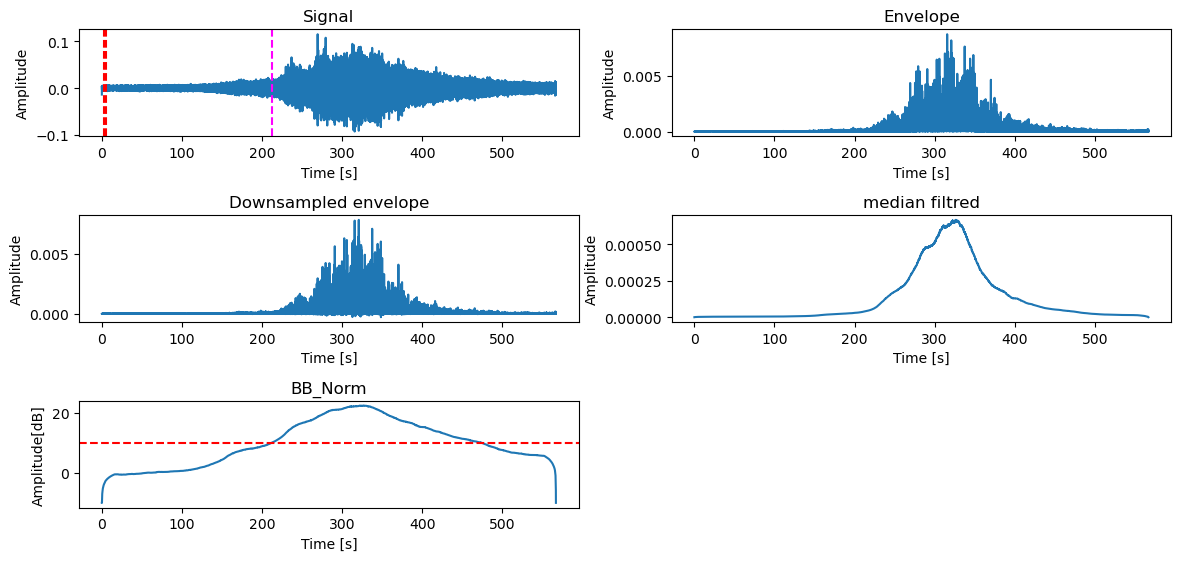

In [17]:
import numpy as np
from functions import spec_hfilt2, medfilt_vertcal_norm, load_audiofile, locate_low_amp
import scipy.signal as signal
from scipy.signal import resample_poly, hilbert
import matplotlib.pyplot as plt

input_file = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"
Fs  = 3000
Sx, Fs = load_audiofile(input_file,Fs, remove_offcet=True)
hilbert_win  = 15
window_size = 30
trigger = 10
plot = False




# Apply Hilbert transform to the signal, take the absolute value, square the result (power envelope), and then apply a median filter
# to smooth the squared analytic signal. The window size for the median filter is defined by `medfilt_window`.
envelope = signal.medfilt(np.square(np.abs(hilbert(Sx))),hilbert_win)

    # Downsample the filtered signal
DS_Sx = resample_poly(envelope, 1, hilbert_win)  # Resample by the median filter window size
DS_Fs = Fs / hilbert_win  # New sampling rate after downsampling

# Define kernel size for the median filter based on window size
kernel_size = int(window_size * DS_Fs) | 1  # Ensure odd size
signal_med = signal.medfilt(DS_Sx, kernel_size)  # Apply median filter for further noise removal

#noise = locate_low_amp(signal_med, kernel_size) #Determine the noise form the signal
# Auto noise detection: Identify long segments of similar values
signal_med2 = signal_med[kernel_size:-kernel_size]  # Remove edges affected by filter size

# Step 1: Identify consecutive regions with the same value (groups)
indices = np.arange(len(signal_med2))  # Create an array of indices
groups = np.split(indices, np.where(np.diff(signal_med2) != 0)[0] + 1)  # Split into groups of similar values

# Step 2: Compute the average amplitude for each group
group_averages = np.array([np.mean(signal_med2[g]) for g in groups])

# Step 3: Define a threshold based on the lowest average amplitude
min_avg = np.min(group_averages)  # Minimum group average
threshold = min_avg * 1.5  # Threshold to allow some variation, 1.5 eq to +- 50%

# Step 4: Find the longest group that is below the threshold
valid_groups = [g for g, avg in zip(groups, group_averages) if avg <= threshold]
longest_group = max(valid_groups, key=len) if valid_groups else None  # Longest valid group

if longest_group is None or len(longest_group) == 0:
    middle_index = None  # No valid group found

# Step 5: Determine the middle index of the longest group
middle_index = kernel_size + longest_group[len(longest_group) // 2]

# Calculate the noise start and stop indices based on the middle of the group
noise_start = int(middle_index - (kernel_size // 2))
noise_stop = int(middle_index + (kernel_size // 2))
noise = np.mean(signal_med[noise_start:noise_stop])  # Calculate the noise level


# Normalize the signal by the noise level and subtract the trigger threshold
norm_vals = np.maximum(signal_med/noise,0.1)
signal_vals = 10 * np.log10(norm_vals) - trigger

# Try to detect trigger times based on the normalized signal
try:
    # Indices where the signal exceeds threshold
    indices = np.where((signal_vals[:-1] <= 0) & (signal_vals[1:] > 0))[0]
    Trigger_time = indices / DS_Fs  # Convert indices to time
except:
    Trigger_time = None  # Set to None if no triggers are found
    print("Warning: Trigger is too high")  # Inform the user if no trigger time is registered
    print("No trigger time registered")

# If plotting is enabled, plot the results
if plot == True:
    BBnorm_t = np.linspace(0, (len(signal_vals) / DS_Fs), len(signal_vals))  # Time vector for the normalized signal

    plt.figure(figsize=(12, 6))  # Set up the figure for plotting
    plt.plot(BBnorm_t, signal_vals + trigger)  # Plot the normalized signal
    plt.axhline(y=trigger, color='red', linestyle='--', label="Trigger")  # Plot the trigger threshold
    plt.title("BBnorm")  # Title of the plot
    plt.xlabel("Time [s]")  # X-axis label
    plt.ylabel("Amplitude [dB]")  # Y-axis label
    plt.show()  # Show the plot





# Plot various stages of the signal processing pipeline for debugging
t = np.linspace(0, len(Sx) / Fs, len(Sx))  # Time vector for the original signal
DS_t = np.linspace(0, len(DS_Sx) / DS_Fs, len(DS_Sx))
plt.figure(figsize=(12, 9))  # Set up the figure for debugging plots

plt.subplot(5, 2, 1)
plt.plot(t, Sx)  # Plot original signal
plt.axvline(x=noise_start / Fs, color='red', linestyle='--')
plt.axvline(x=noise_stop / Fs, color='red', linestyle='--')
plt.axvline(x=Trigger_time[0], color='magenta', linestyle='--')
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 2)
plt.plot(t, envelope)  # Plot analytic signal
plt.title("Envelope")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 3)
plt.plot(DS_t, DS_Sx)  # Plot squared analytic signal
plt.title("Downsampled envelope")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 4)
plt.plot(DS_t, signal_med)  # Plot filtered signal
plt.title("median filtred")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.subplot(5, 2, 5)
BBnorm_t = np.linspace(0, (len(signal_vals) / DS_Fs), len(signal_vals))
plt.plot(BBnorm_t, signal_vals+trigger)  # Plot downsampled signal
plt.title("BB_Norm")
plt.axhline(y=trigger, color='red', linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude[dB]")



plt.tight_layout()  # Adjust layout for better presentation
plt.show()  # Show the debug plots


/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_97302/1104070319.py:57: RuntimeWarning: invalid value encountered in log10
  plt.plot(BB_t2, 10*np.log10(DS_Sx))


' \nMoving avg filter mode full, ta vare på siste kernal/2 og summer med starten av neste segment.\nDette er for å forbedre overgangene mellom hvert segment.\n'

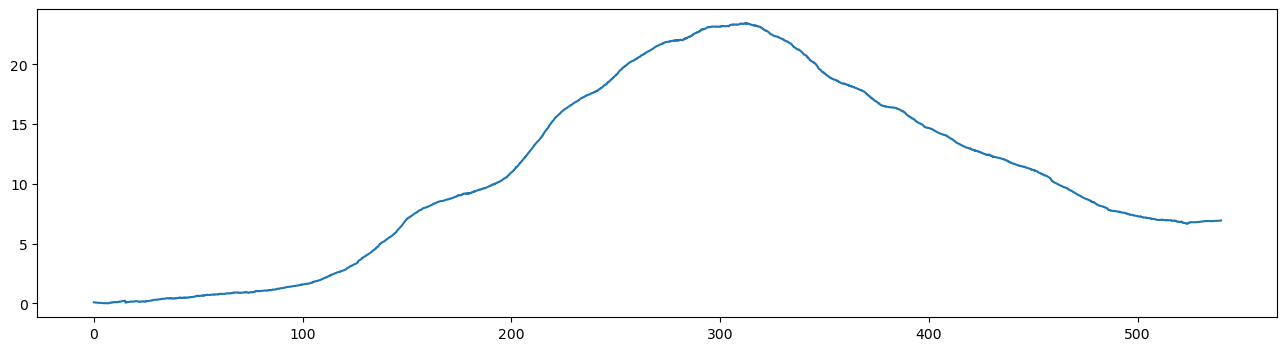

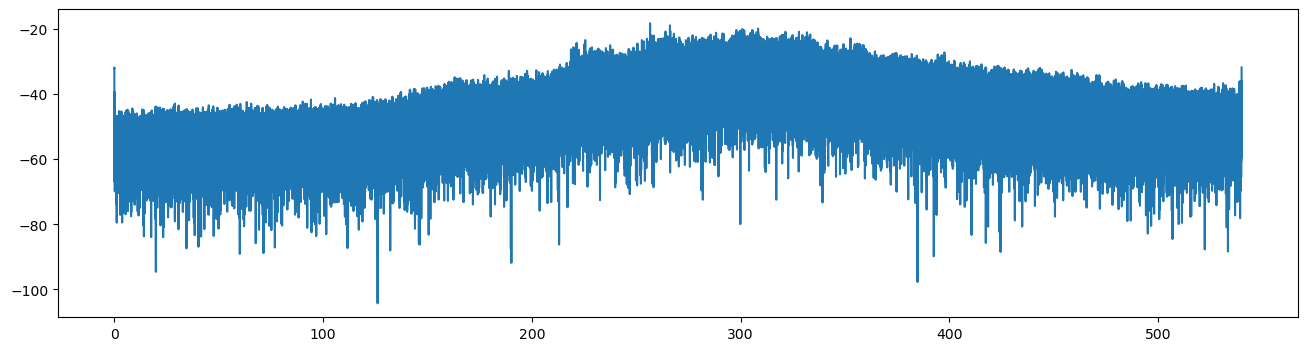

In [ ]:
import functions
import matplotlib.pyplot as plt
import numpy as np
from functions import moving_average_zero_padded, moving_average_edge_padded
from scipy.signal import hilbert, resample_poly


input_path = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"
fs = 10000

Sx, Fs = functions.load_audiofile(input_path, fs, 5, True)

hilbert_win=5
window_size = 30


"""
PARAMETERS:
    sx: array of float
        Audio signal in time domain
    fs: int
        samplerate of sx
    hilbert_win: int
        No. of samples used for downsamlpling
    window_size: float
        No. of seconds used for filtering

RETURN:
    BB_sig: array of float
        Logarithmic representation of power-envelope
    t: array of float
        time array corresponding to BB_sig
"""
# Apply Hilbert transform to the signal, take the absolute value, square the result (power envelope), and then apply a median filter
# to smooth the squared analytic signal. The window size for the median filter is defined by `medfilt_window`.
envelope = moving_average_edge_padded(np.square(np.abs(hilbert(Sx))),hilbert_win)

# Downsample the filtered signal
DS_Sx = resample_poly(envelope, 1, hilbert_win)  # Resample by the median filter window size
DS_Fs = Fs / hilbert_win  # New sampling rate after downsampling

# Define kernel size for the median filter based on window size
kernel_size = int(window_size * DS_Fs) | 1  # Ensure odd size
signal_med = moving_average_zero_padded(DS_Sx, kernel_size)  # Apply median filter for further noise removal

BB_sig = 10*np.log10(signal_med)
t = np.linspace(0,len(BB_sig)/DS_Fs,len(BB_sig))


BB = BB_sig
fig = plt.figure(figsize=(16,4))
BB = BB - np.min(BB)
BB_t2 = np.linspace(0,len(BB)*hilbert_win/fs,len(BB))
plt.plot(BB_t2, BB)

fig2 = plt.figure(figsize=(16,4))
plt.plot(BB_t2, 10*np.log10(DS_Sx))

""" 
Moving avg filter mode full, ta vare på siste kernal/2 og summer med starten av neste segment.
Dette er for å forbedre overgangene mellom hvert segment.
"""


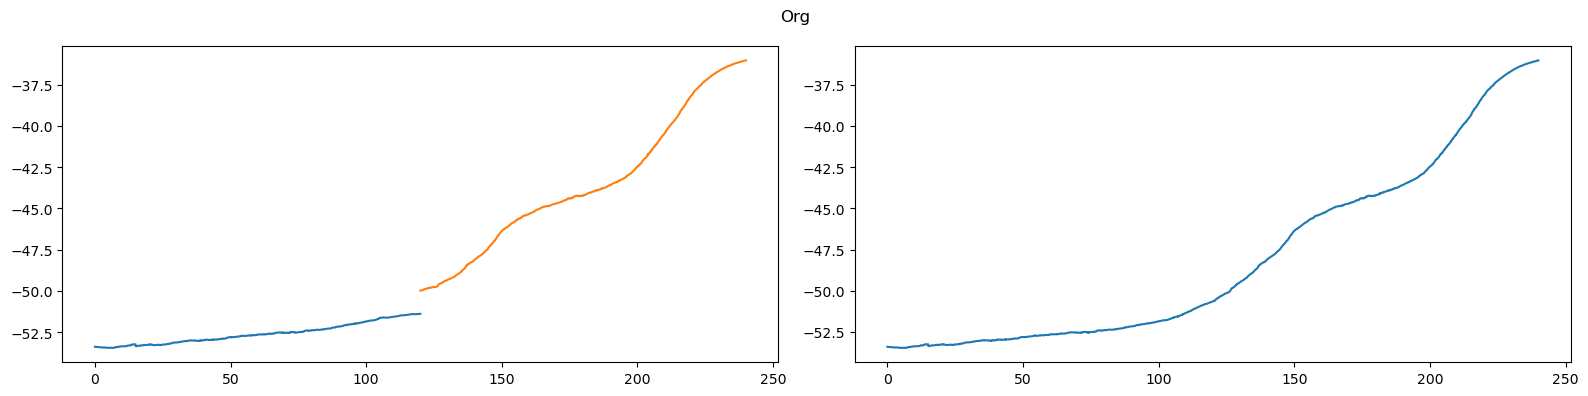

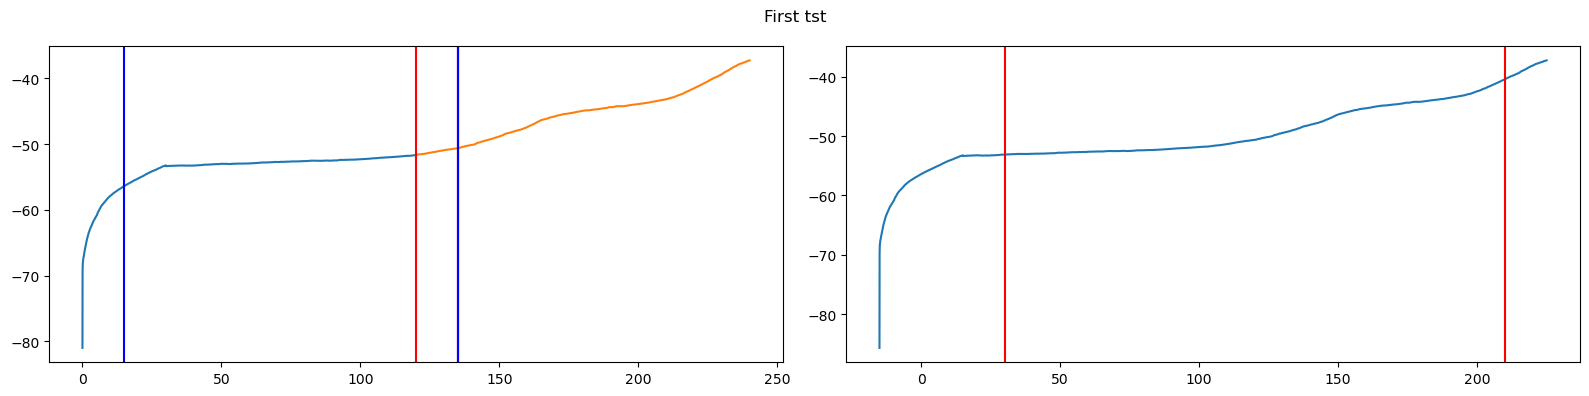

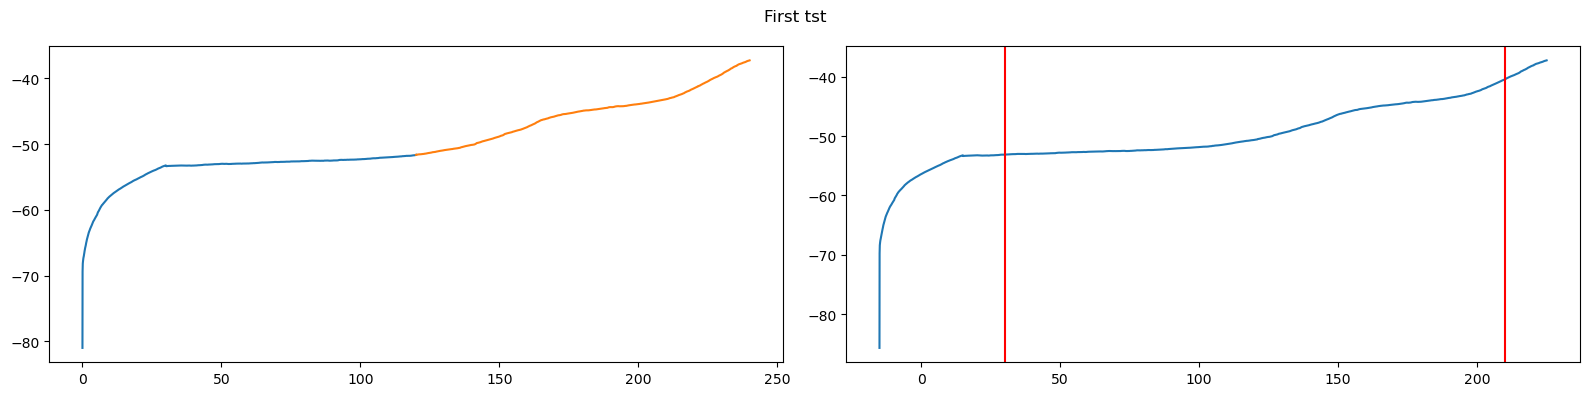

In [ ]:
input_path = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"
import functions
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, resample_poly
fs = 10000
_len = 100
hilbert_win=15
window_size=30

sx_buff = []

sx, fs = functions.load_audiofile(input_path, fs, 5, True)    
sx = sx[:240*fs]

def mavg(sx,fs,sx_buff, hilbert_win, window_size):
    # Apply Hilbert transform to the signal, take the absolute value, square the result (power envelope), and then apply a median filter
    # to smooth the squared analytic signal. The window size for the median filter is defined by `medfilt_window`.
    envelope = functions.moving_average_padded(np.square(np.abs(hilbert(sx))),hilbert_win)

    # Downsample the filtered signal
    DS_Sx = resample_poly(envelope, 1, hilbert_win)  # Resample by the median filter window size
    DS_Fs = fs / hilbert_win  # New sampling rate after downsampling

    # Define kernel size for the median filter based on window size
    kernel_size = int(window_size * DS_Fs) | 1  # Ensure odd size
    signal_med = functions.moving_average_zero_padded(DS_Sx, kernel_size)  # Apply median filter for further noise removal

    #Removing invalid values
    signal_med = signal_med[kernel_size//2:-kernel_size//2]

    #Adding last of previous to start
    signal_med[:len(sx_buff)] += sx_buff

    #Preparing buffer for next segment
    sx_buff_out = signal_med[-kernel_size:]

    #Cutting end of current
    signal_med = signal_med[:-kernel_size]


    BB_sig = 10*np.log10(signal_med)
    t = np.linspace(0,len(BB_sig)/DS_Fs,len(BB_sig))
    return BB_sig, t, sx_buff_out


def plot3(t1,sig1,t2,sig2,t,sig,title:str):
    fig = plt.figure(figsize=(16,4))
    plt.suptitle(title)
    plt.subplot(1,2,1)
    plt.plot(t1,sig1)
    plt.plot(t2,sig2)
    plt.subplot(1,2,2)
    plt.plot(t,sig)
    plt.tight_layout()
    return 0


"""
Plot original på topp

"""
sx1=sx[:120*fs]
sx2=sx[1+120*fs:]

BB_org1, BB_t_org1 = functions.BB_data(sx1,fs,hilbert_win,window_size)
BB_org2, BB_t_org2= functions.BB_data(sx2,fs,hilbert_win,window_size)
BB_org, BB_t_org = functions.BB_data(sx,fs,hilbert_win,window_size)
fig_org = plt.figure(figsize=(16,4))
plt.suptitle("Org")
plt.subplot(1,2,1)
plt.plot(BB_t_org1,BB_org1)
plt.plot(BB_t_org2+120,BB_org2)
plt.subplot(1,2,2)
plt.plot(BB_t_org,BB_org)
plt.tight_layout()


sx_buff_tst1=[]
sx_buff_tst2=[]
sx_buff_tst=[]
BB_tst1, BB_t_tst1, sx_buff_tst1 = mavg(sx1,fs,sx_buff_tst1,hilbert_win,window_size)
BB_tst2, BB_t_tst2, sx_buff_tst2 = mavg(sx2,fs,sx_buff_tst1,hilbert_win,window_size)
BB_tst, BB_t_tst, sx_buff_tst = mavg(sx,fs,sx_buff_tst,hilbert_win,window_size)


fig_tst = plt.figure(figsize=(16,4))
plt.suptitle("First tst")
plt.subplot(1,2,1)
plt.plot(BB_t_tst1,BB_tst1)
plt.axvline(x=15,color="blue") #start of sig
plt.axvline(x=120+15,color="blue") #end of sig

plt.plot(BB_t_tst2+120,BB_tst2)
plt.axvline(x=120,color="red")
plt.axvline(x=120+15,color="red")#start of sig
plt.axvline(x=120+15,color="blue") #end of sig

plt.subplot(1,2,2)
plt.plot(BB_t_tst-15,BB_tst)




plt.axvline(x= window_size,color="red")
plt.axvline(x=len(BB_tst)*hilbert_win/fs - window_size,color="red")
plt.tight_layout()


sx_buff_tst1=[]
sx_buff_tst2=[]
sx_buff_tst=[]
BB_tst1, BB_t_tst1, sx_buff_tst1 = mavg(sx1,fs,sx_buff_tst1,hilbert_win,window_size)
BB_tst2, BB_t_tst2, sx_buff_tst2 = mavg(sx2,fs,sx_buff_tst1,hilbert_win,window_size)
BB_tst, BB_t_tst, sx_buff_tst = mavg(sx,fs,sx_buff_tst,hilbert_win,window_size)

fig_tst = plt.figure(figsize=(16,4))
plt.suptitle("second tst")
plt.subplot(1,2,1)
plt.plot(BB_t_tst1,BB_tst1)

plt.plot(BB_t_tst2+120,BB_tst2)

plt.subplot(1,2,2)
plt.plot(BB_t_tst-15,BB_tst)




plt.axvline(x= window_size,color="red")
plt.axvline(x=len(BB_tst)*hilbert_win/fs - window_size,color="red")
plt.tight_layout()



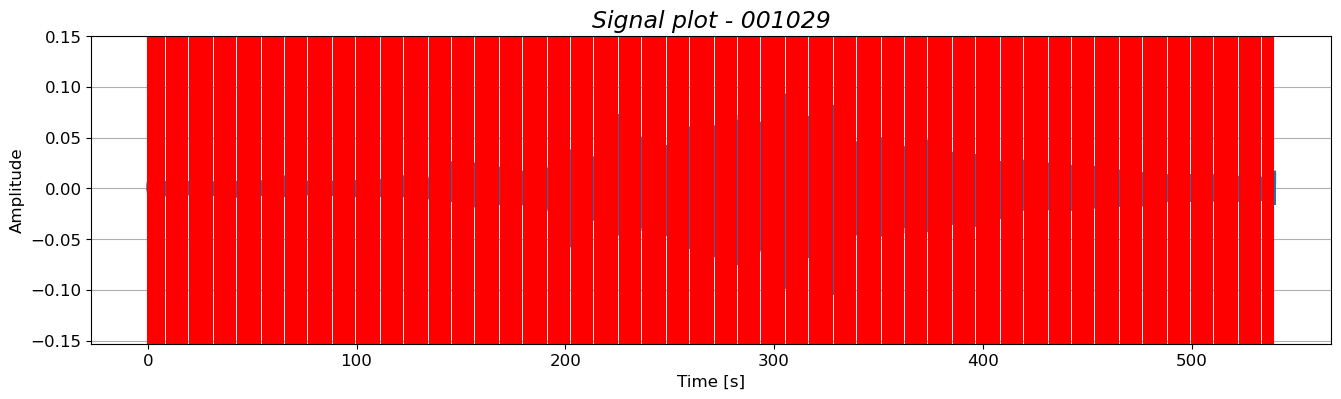

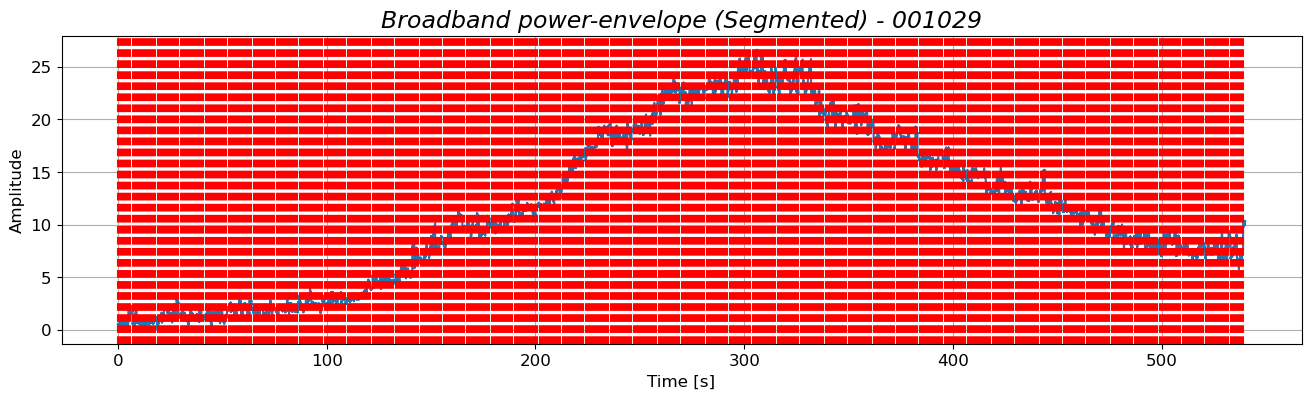

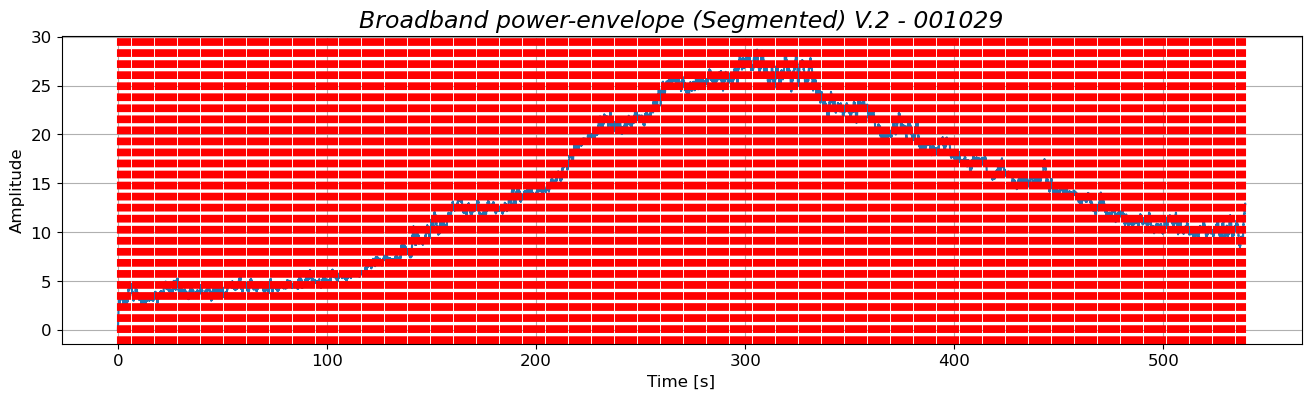

In [1]:


save_path_sig = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/data/Rapport_figs/Signal_001029.png"
save_path_spec = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/data/Rapport_figs/Spec_001029.png"
save_path_demon = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/data/Rapport_figs/Demon_001029.png"
save_path_BB = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/data/Rapport_figs/BroadBand_001029.png"
save_path_BB_segmented = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/data/Rapport_figs/BroadBand_001029_segmented.png"
input_path = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"
import functions
import matplotlib.pyplot as plt
import numpy as np

fs = 44100
_len = 1
hilbert_win=15
window_size=1

sx, fs = functions.load_audiofile(input_path, fs, 5, True)
t = np.linspace(0,len(sx)/fs,len(sx))


fig1 = plt.figure(figsize=(16,4)) #Signal plot
plt.plot(t, sx)

for k in range(0,int(len(sx)/fs),_len):
    plt.axvline(x=k,color="red")
plt.xlabel("Time [s]",fontsize=12)
plt.ylabel("Amplitude",fontsize=12)
plt.title("Signal plot - 001029",fontsize=17, style='italic')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
fig1.savefig(fname=save_path_sig, format="png", dpi=300)


fig5 = plt.figure(figsize=(16,4))
BB = []

for k in range(0,int(len(sx)/fs),_len):
    BB_current, BB_t = functions.BB_data_old(sx[k*fs:((_len+k)*fs)],fs,hilbert_win,window_size)
    BB = np.append(BB,BB_current)

BB = BB - np.min(BB)
BB_t2 = np.linspace(0,len(BB)*hilbert_win/fs,len(BB))
plt.plot(BB_t2, BB)
for k in range(0,int(len(sx)/fs),_len):
    plt.axvline(x=k,color="red",linestyle="--")

plt.xlabel("Time [s]",fontsize=12)
plt.ylabel("Amplitude",fontsize=12)
plt.title("Broadband power-envelope (Segmented) - 001029",fontsize=17, style='italic')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
fig5.savefig(fname=save_path_BB_segmented, format="png", dpi=300)


fig6 = plt.figure(figsize=(16,4))
BB2 = []
sx_buffer = []
for k in range(0,int(len(sx)/fs),_len):
    BB_current, BB_t, sx_buffer = functions.BB_data(sx[k*fs:((_len+k)*fs)],fs,sx_buffer,hilbert_win,window_size)
    BB2 = np.append(BB2,BB_current)

BB2 = BB2 - np.min(BB2)
BB_t2 = np.linspace(0,len(BB2)*hilbert_win/fs,len(BB2))
plt.plot(BB_t2, BB2)
for k in range(0,int(len(sx)/fs),_len):
    plt.axvline(x=k,color="red",linestyle="--")

plt.xlabel("Time [s]",fontsize=12)
plt.ylabel("Amplitude",fontsize=12)
plt.title("Broadband power-envelope (Segmented) V.2 - 001029",fontsize=17, style='italic')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)


In [ ]:
#Live fler-kanal set-up
def BB_data(self, pcm_data: bytes, buff: bytes, hilbert_win: int, window_size: int):
    
    
    channels = self.convert_n_channel_signal_to_n_arrays(pcm_data)

    
    signal_med = []

    for channel in channels:
        # Apply Hilbert transform to the signal, take the absolute value, square the result (power envelope), and then apply a median filter
        # to smooth the squared analytic signal. The window size for the median filter is defined by `medfilt_window`.
        envelope = moving_average_padded(np.square(np.abs(hilbert(channel))),hilbert_win)

        # Downsample the filtered signal
        downsampled_signal = resample_poly(envelope, 1, hilbert_win)  # Resample by the median filter window size
        downsampled_sample_rate = self.sample_rate / hilbert_win  # New sampling rate after downsampling

        # Define kernel size for the median filter based on window size
        kernel_size = int(window_size * downsampled_sample_rate) | 1  # Ensure odd size
        current_signal_med = moving_average_zero_padded(downsampled_signal, kernel_size)  # Apply median filter for further noise removal

        #Removing invalid values
        current_signal_med = signal_med[kernel_size//2:-kernel_size//2]

        #Summing all channels
        signal_med = np.add(signal_med,current_signal_med)
            
    #Adding last of previous to start
    signal_med[:len(buff)] += buff

    #Preparing buffer for next segment
    sx_buff_out = signal_med[-kernel_size:]

    #Cutting end of current
    signal_med = signal_med[:-kernel_size]

    if len(buff) == 0: #Empty buffer
        signal_med = signal_med[kernel_size//2:] #Kutter fÃ¸rste del


    BB_sig = 10*np.log10(signal_med)
    t = np.linspace(0,len(BB_sig)/downsampled_sample_rate,len(BB_sig))
    return BB_sig, t, sx_buff_out
